# Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import time

In [ ]:
from multiprocessing import Pool, cpu_count

In [ ]:
# Parallel apply
def parallel_apply(series, func, workers=cpu_count()):
    with Pool(workers) as pool:
        return pool.map(func, series)

In [ ]:
import tensorflow as tf

# List GPUs detected
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Check memory details
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5424674977745796897
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17514282941758592321
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labeled(4)_reddit_credit_card_discussion.csv")

In [ ]:
df.drop(columns=["comment_clean"], inplace=True)

In [ ]:
df.head()

,comment,category
0,The mods would be updating the post on a regul...,recommendation
1,You've done god's work bro,recommendation
2,"I appreciate you including my posts, it was an...",recommendation
3,Kiwi rupay upi devaluation linked incorrectly,complaint
4,Great work,recommendation


In [ ]:
df["category"].value_counts()

,count
category,
recommendation,2745
query,2241
complaint,1723
experience,1092


In [ ]:
print(df.isnull().sum())

comment     0
category    0
dtype: int64


In [ ]:
print(df.duplicated().sum())

0


# Text Prepocessing

In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 9.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d31fd1ebf21f5ecb33a907443ad1087fe7ff51cfdeaf66b1ba3a23baf23dbd0b
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=f48dd6437066aaea7a89ecc90005639c5e6245a4268bded2048b98d4bf6ccd75
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import re
import string
import emoji
from num2words import num2words
from langdetect import detect
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#### 1. Lowercasing

In [ ]:
def to_lowercase(text):
    return text.lower()

In [ ]:
df["clean_comment"] = df["comment"].map(to_lowercase)

#### 2. Emoji Reomval

In [ ]:
def remove_emojis(text):
    try:
        return emoji.replace_emoji(text, replace='')
    except:
        return text

In [ ]:
df["clean_comment"] = df["clean_comment"].map(remove_emojis)

#### 3. Removing Numbers

In [ ]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df["clean_comment"] = df["clean_comment"].map(remove_numbers)

#### 4. Punctuation Removal

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df["clean_comment"] = df["clean_comment"].map(remove_punctuation)

#### 5. Removing line breaks, hyphens & extra-spaces

In [ ]:
def remove_line_breaks(text):
    return text.replace('\n', ' ').replace('-', ' ').replace('_', ' ').replace('\r', ' ')

df["clean_comment"] = df["clean_comment"].map(remove_line_breaks)

#### 6. Chat Word Expansion

In [ ]:
# Large chatwords dictionary
chat_words_map = {
    "u": "you", "ur": "your", "urs": "yours", "u've": "you have", "u'll": "you will", "u'r": "you are",
    "im": "i am", "i'm": "i am", "i'll": "i will", "i'd": "i would", "i've": "i have",
    "cant": "cannot", "can't": "cannot", "cud": "could", "cudnt": "could not", "couldnt": "could not",
    "dont": "do not", "don't": "do not", "doesnt": "does not", "doesn't": "does not",
    "didnt": "did not", "didn't": "did not",
    "wont": "will not", "won't": "will not", "wouldnt": "would not", "wouldn't": "would not",
    "shouldnt": "should not", "shouldn't": "should not", "shud": "should", "shudnt": "should not",
    "mustnt": "must not", "mustn't": "must not", "musnt": "must not",
    "idk": "i do not know", "ikr": "i know right", "btw": "by the way", "omg": "oh my god",
    "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing", "lol": "laugh out loud",
    "thx": "thanks", "tnx": "thanks", "ty": "thank you", "tq": "thank you", "thanx": "thanks",
    "plz": "please", "pls": "please", "ppl": "people", "b4": "before", "gr8": "great",
    "w8": "wait", "4u": "for you", "2day": "today", "2moro": "tomorrow", "2nite": "tonight",
    "bday": "birthday", "gf": "girlfriend", "bf": "boyfriend", "bff": "best friends forever",
    "cuz": "because", "coz": "because", "bc": "because", "bcoz": "because", "becoz": "because",
    "atm": "at the moment", "afaik": "as far as i know", "brb": "be right back",
    "bbl": "be back later", "bfn": "bye for now", "gtg": "got to go", "g2g": "got to go",
    "omw": "on my way", "ttyl": "talk to you later", "ttys": "talk to you soon",
    "np": "no problem", "nvm": "never mind", "fyi": "for your information", "asap": "as soon as possible",
    "tbh": "to be honest", "smh": "shaking my head", "imo": "in my opinion", "imho": "in my humble opinion",
    "wtf": "what the heck", "wth": "what the heck", "wyd": "what are you doing", "wya": "where are you at",
    "sup": "what is up", "yo": "hello", "xoxo": "hugs and kisses",
    "jk": "just kidding", "jkjk": "just kidding", "np": "no problem", "yw": "you are welcome",
    "hmu": "hit me up", "ily": "i love you", "ilu": "i love you", "ilu2": "i love you too",
    "muah": "kiss", "mwah": "kiss", "icymi": "in case you missed it",
    "fomo": "fear of missing out", "bae": "before anyone else",
    # Numbers as words
    "1st": "first", "2nd": "second", "3rd": "third", "4th": "fourth", "5th": "fifth",
    "b4n": "bye for now", "gratz": "congratulations", "congrats": "congratulations",
    "hbd": "happy birthday", "gm": "good morning", "gn": "good night",
    # Slang & more
    "k": "okay", "kk": "okay", "okie": "okay", "okies": "okay",
    "ya": "yes", "yea": "yeah", "yup": "yes", "nope": "no", "nah": "no",
    "luv": "love", "wuv": "love", "xmas": "christmas", "nite": "night",
    "msg": "message", "txt": "text", "pic": "picture", "dp": "display picture",
    "vid": "video", "dm": "direct message", "pm": "private message",
    "bcuz": "because", "becuz": "because", "bcus": "because", "bcos": "because",
    "cu": "see you", "cya": "see you", "l8r": "later", "gg": "good game",
    "irl": "in real life", "idc": "i do not care", "iirc": "if i remember correctly",
    "otp": "one time password", "faq": "frequently asked questions", "bio": "biography",
    "pic": "picture", "dp": "display picture", "omfg": "oh my freaking god",
    "fml": "forget my life", "bruh": "brother", "sis": "sister",
    #
    "cc":"credit card"
}

def expand_chatwords(text):
    text = str(text).lower()
    for word, expanded in chat_words_map.items():
        text = re.sub(r'\b' + re.escape(word) + r'\b', expanded, text)
    return text

In [ ]:
df["clean_comment"] = df["clean_comment"].map(expand_chatwords)

#### 7. Language Detection

In [ ]:
def detect_language(text):
    try:
        if not text or text.strip() == "":
            return None  # empty or whitespace
        lang = detect(text)
        if lang == 'en':
            return text
        else:
            return None
    except LangDetectException:
        return None

In [ ]:
df.shape

(7801, 3)

In [ ]:
df = df.dropna(subset=['clean_comment'])
df = df[df['clean_comment'].str.strip() != ""]

In [ ]:
df.shape

(7764, 3)

In [ ]:
df["clean_comment"] = df["clean_comment"].map(detect_language)

In [ ]:
df = df.dropna(subset=['clean_comment'])
df = df[df['clean_comment'].str.strip() != ""]

In [ ]:
df.shape

(7073, 3)

#### 9. Tokenization

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def tokenize_text(text):
    return word_tokenize(text)

In [ ]:
df["comment_tokens"] = df["clean_comment"].map(tokenize_text)

In [ ]:
df.head()

,comment,category,clean_comment,comment_tokens
0,The mods would be updating the post on a regul...,recommendation,the mods would be updating the post on a regul...,"[the, mods, would, be, updating, the, post, on..."
2,"I appreciate you including my posts, it was an...",recommendation,i appreciate you including my posts it was an ...,"[i, appreciate, you, including, my, posts, it,..."
3,Kiwi rupay upi devaluation linked incorrectly,complaint,kiwi rupay upi devaluation linked incorrectly,"[kiwi, rupay, upi, devaluation, linked, incorr..."
5,Nice work team.,recommendation,nice work team,"[nice, work, team]"
6,Axis Neo devaluation linked incorrectly.,complaint,axis neo devaluation linked incorrectly,"[axis, neo, devaluation, linked, incorrectly]"


#### 10. POS Tagging & Lemmatization

In [ ]:
from nltk import pos_tag
from nltk.corpus import wordnet

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# POS map for faster lookup
pos_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
}

def get_wordnet_pos(tag):
    return pos_map.get(tag[0], wordnet.NOUN)

# Lemmatization function for one text
def lemmatize_text(tokens):
    pos_tags = pos_tag(tokens)
    return " ".join(
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    )

In [ ]:
df["comment_lemmatized"] = parallel_apply(df["comment_tokens"], lemmatize_text)

In [ ]:
df.head()

,comment,category,clean_comment,comment_tokens,comment_lemmatized
0,The mods would be updating the post on a regul...,recommendation,the mods would be updating the post on a regul...,"[the, mods, would, be, updating, the, post, on...",the mod would be update the post on a regular ...
2,"I appreciate you including my posts, it was an...",recommendation,i appreciate you including my posts it was an ...,"[i, appreciate, you, including, my, posts, it,...",i appreciate you include my post it be an honor
3,Kiwi rupay upi devaluation linked incorrectly,complaint,kiwi rupay upi devaluation linked incorrectly,"[kiwi, rupay, upi, devaluation, linked, incorr...",kiwi rupay upi devaluation link incorrectly
5,Nice work team.,recommendation,nice work team,"[nice, work, team]",nice work team
6,Axis Neo devaluation linked incorrectly.,complaint,axis neo devaluation linked incorrectly,"[axis, neo, devaluation, linked, incorrectly]",axis neo devaluation link incorrectly


#### 11. Stop Word Removal

In [ ]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words and len(word) > 1])

In [ ]:
df["comment_no_stopword"] = df['clean_comment'].map(remove_stopwords)

In [ ]:
df.head()

,comment,category,clean_comment,comment_tokens,comment_lemmatized,comment_no_stopword
0,The mods would be updating the post on a regul...,recommendation,the mods would be updating the post on a regul...,"[the, mods, would, be, updating, the, post, on...",the mod would be update the post on a regular ...,mods would updating post regular basis find po...
2,"I appreciate you including my posts, it was an...",recommendation,i appreciate you including my posts it was an ...,"[i, appreciate, you, including, my, posts, it,...",i appreciate you include my post it be an honor,appreciate including posts honor
3,Kiwi rupay upi devaluation linked incorrectly,complaint,kiwi rupay upi devaluation linked incorrectly,"[kiwi, rupay, upi, devaluation, linked, incorr...",kiwi rupay upi devaluation link incorrectly,kiwi rupay upi devaluation linked incorrectly
5,Nice work team.,recommendation,nice work team,"[nice, work, team]",nice work team,nice work team
6,Axis Neo devaluation linked incorrectly.,complaint,axis neo devaluation linked incorrectly,"[axis, neo, devaluation, linked, incorrectly]",axis neo devaluation link incorrectly,axis neo devaluation linked incorrectly


# Train-Test Split

In [ ]:
df.head(1)

,comment,category,clean_comment,comment_tokens,comment_lemmatized,comment_no_stopword
0,The mods would be updating the post on a regul...,recommendation,the mods would be updating the post on a regul...,"[the, mods, would, be, updating, the, post, on...",the mod would be update the post on a regular ...,mods would updating post regular basis find po...


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(df['category'])

X = df['comment_lemmatized']

X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, stratify=y, random_state=42
          )

# Text Representation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# method - 1
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, sublinear_tf=True)
# tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
# tfidf = TfidfVectorizer()

In [ ]:
# method - 2
# tfidf = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=20000)    # give accuracy low

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf.shape

(5658, 20000)

#### Word2vec

In [ ]:
# !pip install gensim
# import gensim
# from gensim.models import Word2Vec

In [ ]:
# # Create and train model
# w2v_model = Word2Vec(
#     sentences=df["comment_tokens"],
#     vector_size=100,   # embedding size
#     window=5,          # context window size
#     min_count=1,       # ignore words with frequency < 1
#     sg=1               # 1 = skip-gram, 0 = CBOW
# )

# # Save model
# w2v_model.save("word2vec.model")


# # Function to average word vectors for each document
# def document_vector(tokens):
#   tokens = [word for word in tokens if word in w2v_model.wv]
#   if len(tokens) == 0:
#     return np.zeros(w2v_model.vector_size) # empty doc
#   return np.mean(w2v_model.wv[tokens], axis=0)

# # Apply to df
# df["comment_vector"] = df["comment_tokens"].apply(document_vector)


# X = np.vstack(df["comment_vector"].values)  # feature matrix
# y = df["category"]  # target labels


# from sklearn.preprocessing import LabelEncoder

# # Encode target labels
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Now split
# X_train, X_test, y_train, y_test = train_test_split(
#           X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
#           )


## Modeling

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

### Logistic Regression & Linear SVM

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Linear SVM
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

In [ ]:
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

print("\n","\n")

print("Linear SVM:")
print(classification_report(y_test, y_pred_svm))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       309
           1       0.38      0.46      0.42       203
           2       0.66      0.56      0.61       412
           3       0.64      0.61      0.62       491

    accuracy                           0.55      1415
   macro avg       0.53      0.53      0.53      1415
weighted avg       0.56      0.55      0.55      1415


 

Linear SVM:
              precision    recall  f1-score   support

           0       0.45      0.43      0.44       309
           1       0.41      0.41      0.41       203
           2       0.63      0.59      0.61       412
           3       0.61      0.64      0.63       491

    accuracy                           0.55      1415
   macro avg       0.52      0.52      0.52      1415
weighted avg       0.55      0.55      0.55      1415



In [ ]:
# confusion matrix - logistic
print("Logistic Regression:")
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)
print(pd.DataFrame(cm_lr, index=lr.classes_, columns=lr.classes_))

print("\n")

# confusion matrix - svm
print("Linear SVM:")
cm = confusion_matrix(y_test, y_pred_svm, labels=svm.classes_)
print(pd.DataFrame(cm, index=svm.classes_, columns=svm.classes_))

Logistic Regression:
     0   1    2    3
0  150  52   40   67
1   64  94   21   24
2   65  36  231   80
3   66  68   59  298


Linear SVM:
     0   1    2    3
0  134  42   49   84
1   55  84   29   35
2   54  31  245   82
3   58  50   68  315


#### Handling Class Imbalance
1. Class Weight Learing

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)  # See how much more "experience" is weighted

{np.int64(0): np.float64(1.1444174757281553), np.int64(1): np.float64(1.7484548825710755), np.int64(2): np.float64(0.8583131067961165), np.int64(3): np.float64(0.7198473282442748)}


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight=class_weights)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Linear SVM
svm = LinearSVC(class_weight=class_weights)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

In [ ]:
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

print("\n","\n")

print("Linear SVM:")
print(classification_report(y_test, y_pred_svm))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       309
           1       0.38      0.46      0.42       203
           2       0.66      0.56      0.61       412
           3       0.64      0.61      0.62       491

    accuracy                           0.55      1415
   macro avg       0.53      0.53      0.53      1415
weighted avg       0.56      0.55      0.55      1415


 

Linear SVM:
              precision    recall  f1-score   support

           0       0.45      0.43      0.44       309
           1       0.41      0.41      0.41       203
           2       0.63      0.59      0.61       412
           3       0.61      0.64      0.63       491

    accuracy                           0.55      1415
   macro avg       0.52      0.52      0.52      1415
weighted avg       0.55      0.55      0.55      1415



- This method is of no help. Instead of improving, it is degrading.

2. Resampling the Training Data

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_tfidf, y_train)

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_res, y_res)
y_pred_lr = lr.predict(X_test_tfidf)

# Linear SVM
svm = LinearSVC(class_weight='balanced')
svm.fit(X_res, y_res)
y_pred_svm = svm.predict(X_test_tfidf)

In [ ]:
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

print("\n","\n")

print("SVM:")
print(classification_report(y_test, y_pred_svm))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.43      0.47      0.45       309
           1       0.40      0.45      0.42       203
           2       0.66      0.58      0.61       412
           3       0.62      0.62      0.62       491

    accuracy                           0.55      1415
   macro avg       0.53      0.53      0.53      1415
weighted avg       0.56      0.55      0.55      1415


 

SVM:
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       309
           1       0.40      0.40      0.40       203
           2       0.62      0.60      0.61       412
           3       0.61      0.63      0.62       491

    accuracy                           0.54      1415
   macro avg       0.51      0.51      0.51      1415
weighted avg       0.54      0.54      0.54      1415



### Multinomial Naïve Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print("Multinomial Naïve Bayes:")
print(classification_report(y_test, y_pred_nb))

Multinomial Naïve Bayes:
              precision    recall  f1-score   support

           0       0.58      0.10      0.17       309
           1       1.00      0.01      0.03       203
           2       0.66      0.52      0.58       412
           3       0.44      0.93      0.60       491

    accuracy                           0.50      1415
   macro avg       0.67      0.39      0.34      1415
weighted avg       0.61      0.50      0.42      1415



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.42      0.37      0.39       309
           1       0.56      0.12      0.20       203
           2       0.65      0.57      0.61       412
           3       0.52      0.79      0.63       491

    accuracy                           0.54      1415
   macro avg       0.54      0.46      0.46      1415
weighted avg       0.54      0.54      0.51      1415



### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train_tfidf, y_train_enc)
y_pred_xgb = xgb.predict(X_test_tfidf)

print("XGBoost:")
print(classification_report(y_test_enc, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.45      0.39      0.42       309
           1       0.56      0.17      0.26       203
           2       0.68      0.53      0.60       412
           3       0.51      0.79      0.62       491

    accuracy                           0.54      1415
   macro avg       0.55      0.47      0.47      1415
weighted avg       0.55      0.54      0.52      1415



### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm.fit(X_train_tfidf, y_train)
y_pred_lgb = lgbm.predict(X_test_tfidf)

print("LightGBM:")
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38110
[LightGBM] [Info] Number of data points in the train set: 5658, number of used features: 1375
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
LightGBM:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       309
           1       0.46      0.39      0.42       203
           2       0.61      0.59      0.60       412
           3       0.61      0.65      0.63       491

    accuracy                           0.55      1415
   macro avg       0.53      0.52      0.52      1415
weighted avg       0.55      0.55      

# Clustering

In [ ]:
df1 = df.copy()

## K-Means

In [ ]:
df.head(1)

,comment,category,clean_comment,comment_tokens,comment_lemmatized,comment_no_stopword
0,The mods would be updating the post on a regul...,recommendation,the mods would be updating the post on a regul...,"[the, mods, would, be, updating, the, post, on...",the mod would be update the post on a regular ...,mods would updating post regular basis find po...


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
# Vectorize text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, sublinear_tf=True)

X_tfidf = vectorizer.fit_transform(df['comment_no_stopword'])

In [ ]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)

# Add cluster labels to dataframe
df['cluster'] = clusters

# Unsupervised evaluation
silhouette = silhouette_score(X_tfidf, clusters)
calinski = calinski_harabasz_score(X_tfidf.toarray(), clusters)
davies = davies_bouldin_score(X_tfidf.toarray(), clusters)

In [ ]:
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Score: {calinski:.3f}")
print(f"Davies-Bouldin Score: {davies:.3f}")

# Inspect cluster examples
for i in range(4):
    print(f"\nCluster {i} examples:")
    print(df[df['cluster'] == i]['comment_lemmatized'].head(5).to_list())

Silhouette Score: 0.003
Calinski-Harabasz Score: 17.054
Davies-Bouldin Score: 12.698

Cluster 0 examples:
['the mod would be update the post on a regular basis if you find any post that you think be worth add here please mention it in the comment we will review it', 'i appreciate you include my post it be an honor', 'kiwi rupay upi devaluation link incorrectly', 'nice work team', 'axis neo devaluation link incorrectly']

Cluster 1 examples:
['need okay marriott bonvoy point offer be welcome', 'smartbuy voucher code of okay available for okay last booking date august', 'okay worth the body shop gv available for sale offer price let me know if youre interested', 'net monthly credit okay okay', 'op ’ s net be okay i doubt they can get']

Cluster 2 examples:
['there be one technofino link for sbi cashback card merchant list for cashback eligibility', 'add a section specific to forex spends markup travel card which one be the best which one be zero forex markup etc', 'hello fam kindly enlig

## Agglomerative Clustering

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# # ==== 1. Text Cleaning Function ====
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def clean_text(text):
#     text = str(text).lower()
#     text = re.sub(r'[^a-z\s]', '', text)  # keep only letters and spaces
#     tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
#     return ' '.join(tokens)

# # Load your data
# # df = pd.read_csv("your_comments_file.csv")  # replace with your file
# df['cleaned'] = df['comment_lemmatized'].apply(clean_text)  # change column name

In [ ]:
# ==== 3. Dimensionality Reduction (Optional but recommended) ====
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

In [ ]:
# ==== 4. Agglomerative Clustering ====
n_clusters = 4  # you can change this
agg_clust = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = agg_clust.fit_predict(X_reduced)

df['Agg_cluster'] = cluster_labels

# ==== 5. Evaluation ====
sil_score = silhouette_score(X_reduced, cluster_labels)
calinski_score = calinski_harabasz_score(X_reduced, cluster_labels)
davies_score = davies_bouldin_score(X_reduced, cluster_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {calinski_score:.3f}")
print(f"Davies-Bouldin Score: {davies_score:.3f}")


Silhouette Score: 0.184
Calinski-Harabasz Score: 115.344
Davies-Bouldin Score: 1.886


- It has also been verified that n_clusters=4, is best in the range(2,11)

# Embedding

In [ ]:
!pip install -q sentence-transformers hdbscan umap-learn

from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 679.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00


In [ ]:
comments = df["comment_lemmatized"].astype(str).tolist()


In [ ]:
# 1. Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# UMAP + HDBSCAN

In [ ]:
embeddings = model.encode(comments, show_progress_bar=True)

# 2. Dimensionality reduction (UMAP)
umap_reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42)

Batches:   0%|          | 0/222 [00:00<?, ?it/s]

In [ ]:
embeddings_umap = umap_reducer.fit_transform(embeddings)

# 3. Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
labels = clusterer.fit_predict(embeddings_umap)

# 4. Evaluation (only works if >1 cluster and no noise)
if len(set(labels)) > 1:# and -1 not in set(labels):
    sil = silhouette_score(embeddings_umap, labels)
    ch = calinski_harabasz_score(embeddings_umap, labels)
    db = davies_bouldin_score(embeddings_umap, labels)
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Calinski-Harabasz Score: {ch:.3f}")
    print(f"Davies-Bouldin Score: {db:.3f}")
    print("Number of clusters",len(set(labels)))
else:
    print("Evaluation skipped: clustering resulted in noise or a single cluster.")

Silhouette Score: 0.052
Calinski-Harabasz Score: 22.900
Davies-Bouldin Score: 1.173
Number of clusters 722


In [ ]:
labels.sort()

In [ ]:
# 5. View clusters
for c_id in set(labels):
    cluster_comments = [comments[i] for i, lbl in enumerate(labels) if lbl == c_id]
    print(f"\nCluster {c_id}:")
    for comment in cluster_comments:
        print(f" - {comment}")


Streaming output truncated to the last 5000 lines.
 - one card give
 - sbi bob return and no reward redemption fee
 - if your fuel need be less than say per year then get bpcl if more than that then get bpcl octanebpcl have annual fee of and bpcl have annual fee of bpcl give cashback in reward and bpcl octane give also remember to get rupay upi cardmakes payment easy
 - and can we not get the annual fee waive off
 - will count for rg milestone will not get anything on others
 - any luck with amex gold charge

Cluster 391:
 - yeah will count for okay x milestone
 - will only get the okay bonus on okay x txn milestone not the regular mr

Cluster 392:
 - it an stupid bank they reject every one they reject my friend time and customer care have no idea apply card to card basis after month
 - mine be reject too randomly i email them to give a reason and i be tell the reason that i have too many unsecured credit card high risk laugh out loud i do end up get approve when i apply in march when 

Number of clusters 722


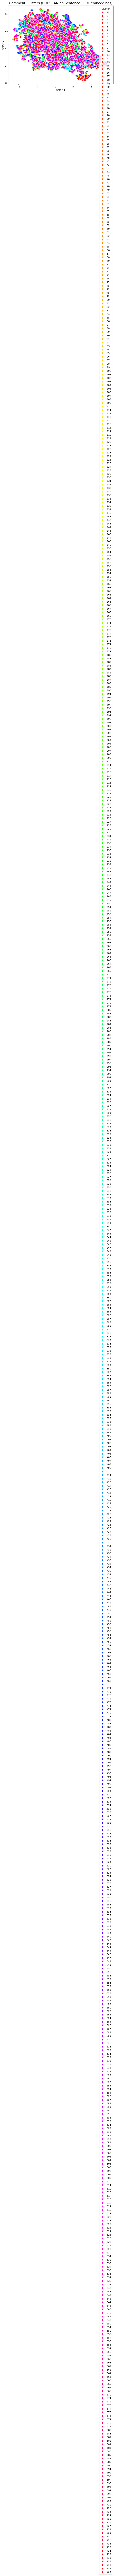

In [ ]:
umap_2d = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embeddings_2d = umap_2d.fit_transform(embeddings)

print("Number of clusters",len(set(labels)))
# 6. Visualization
plt.figure(figsize=(8, 6))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    hue=labels, palette=palette, legend="full", s=60
)
plt.title("Comment Clusters (HDBSCAN on Sentence-BERT embeddings)", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.show()


# KMeans Clustering on Embeddings

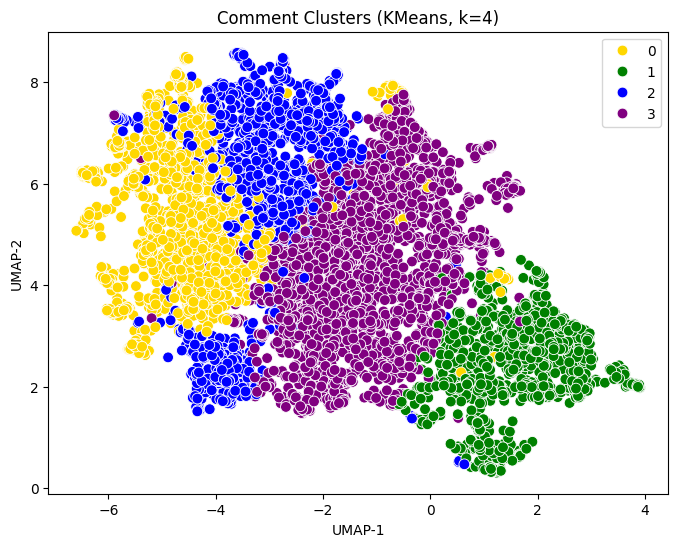

In [ ]:
# Use the 5D UMAP-reduced embeddings for better clustering
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# KMeans with fixed number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(umap_embeddings)

# 2D projection for plotting
umap_2d = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

colors = ["gold",
          "green",
          "blue",
          "purple"]

# Plot
plt.figure(figsize=(8, 6))
palette = sns.color_palette("hsv", 4)
sns.scatterplot(
    x=umap_2d[:,0], y=umap_2d[:, 1],
    hue=labels, palette=colors, legend="full", s=60
)
plt.title("Comment Clusters (KMeans, k=4)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [ ]:
# Assuming:
# - comments is a list or pandas Series of your original text data
# - labels is your KMeans labels array (kmeans.labels_)

new_df = pd.DataFrame({"comment": comments, "cluster": labels})

# Function to get top keywords per cluster
def get_top_keywords_per_cluster(new_df, num_keywords=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
    X = vectorizer.fit_transform(new_df["comment"])
    terms = vectorizer.get_feature_names_out()

    top_keywords = {}
    for cluster_id in sorted(new_df["cluster"].unique()):
        cluster_indices = new_df[new_df["cluster"] == cluster_id].index
        cluster_tfidf = X[cluster_indices].mean(axis=0)
        top_term_indices = cluster_tfidf.A1.argsort()[::-1][:num_keywords]
        top_terms = [terms[i] for i in top_term_indices]
        top_keywords[cluster_id] = top_terms
    return top_keywords

top_keywords = get_top_keywords_per_cluster(new_df, num_keywords=10)

# Display results
for cluster_id, keywords in top_keywords.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")


Cluster 0: card, cashback, use, pay, reward, amazon, point, credit, axis, rupay
Cluster 1: thanks, app, new, thank, yes, try, work, yeah, check, know
Cluster 2: card, sbi, hdfc, ltf, credit, use, cashback, good, offer, apply
Cluster 3: card, credit, bank, limit, month, account, okay, pay, apply, day


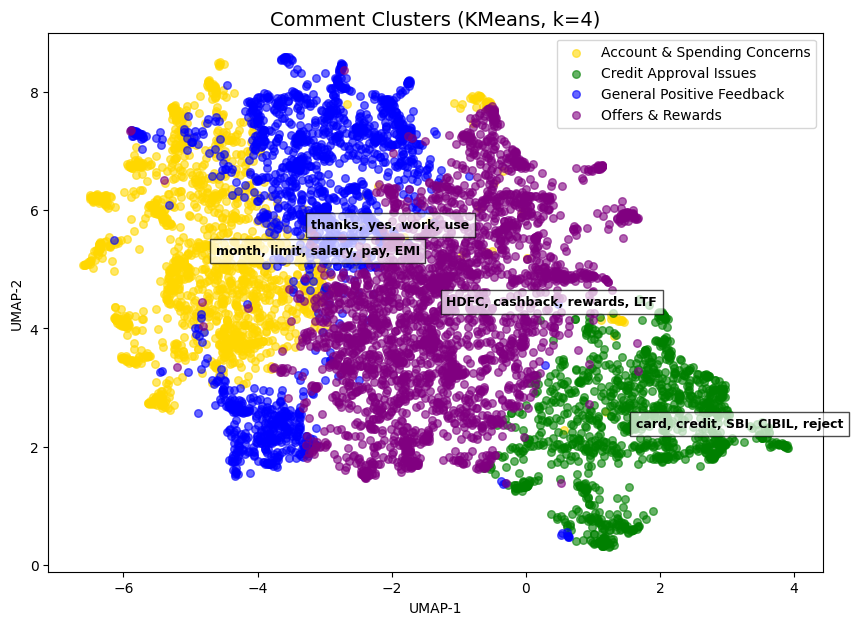

In [ ]:
df1 = df.copy()

# Create DataFrame with UMAP coords + cluster labels
df = pd.DataFrame({
    'umap_x': embeddings_2d[:, 0],
    'umap_y': embeddings_2d[:, 1],
    'cluster': labels
})

# Map cluster IDs to descriptive names
cluster_names = {
    0: "Account & Spending Concerns",
    1: "Credit Approval Issues",
    2: "General Positive Feedback",
    3: "Offers & Rewards"
}
df['cluster_name'] = df['cluster'].map(cluster_names)

# Top keywords for annotation
cluster_keywords = {
    "Account & Spending Concerns": "month, limit, salary, pay, EMI",
    "Credit Approval Issues": "card, credit, SBI, CIBIL, reject",
    "General Positive Feedback": "thanks, yes, work, use",
    "Offers & Rewards": "HDFC, cashback, rewards, LTF"
}

# Color palette
colors = {
    "Account & Spending Concerns": "gold",
    "Credit Approval Issues": "green",
    "General Positive Feedback": "blue",
    "Offers & Rewards": "purple"
}

# Plot
plt.figure(figsize=(10, 7))
for name, group in df.groupby('cluster_name'):
    plt.scatter(group['umap_x'], group['umap_y'],
                c=colors[name], label=name, alpha=0.6, s=30)

# Annotate cluster centers
for name, group in df.groupby('cluster_name'):
    center_x = group['umap_x'].mean()
    center_y = group['umap_y'].mean()
    plt.text(center_x, center_y,
             cluster_keywords[name],
             fontsize=9, weight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.title("Comment Clusters (KMeans, k=4)", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.show()


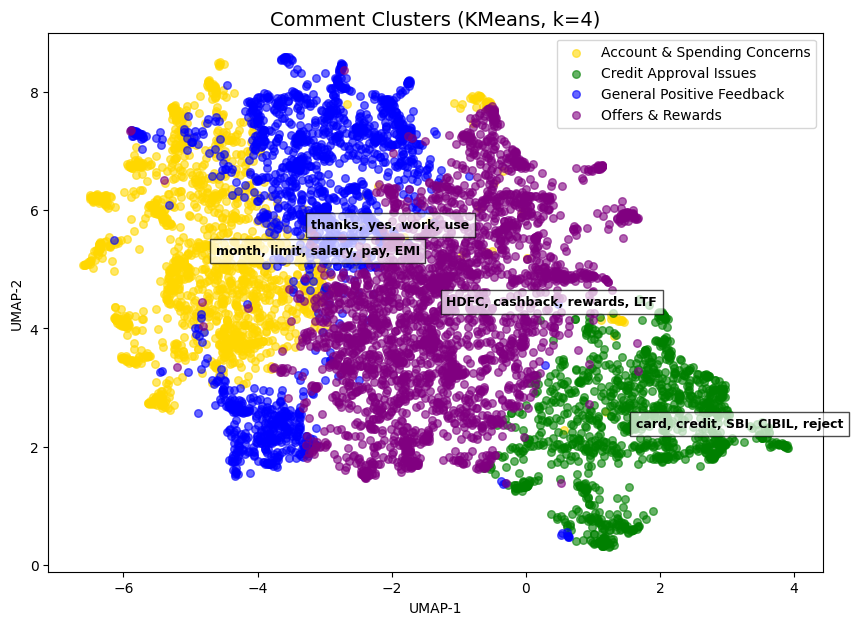

In [ ]:
# Example: your DataFrame with numeric cluster IDs and UMAP coords
# df should have columns: 'umap_x', 'umap_y', 'cluster'
# Replace this with your actual DataFrame variable name
# df = ...

# Map numeric cluster IDs to descriptive names
cluster_names = {
    0: "Account & Spending Concerns",
    1: "Credit Approval Issues",
    2: "General Positive Feedback",
    3: "Offers & Rewards"
}

df['cluster_name'] = df['cluster'].map(cluster_names)

# Define top keywords for annotation
cluster_keywords = {
    "Account & Spending Concerns": "month, limit, salary, pay, EMI",
    "Credit Approval Issues": "card, credit, SBI, CIBIL, reject",
    "General Positive Feedback": "thanks, yes, work, use",
    "Offers & Rewards": "HDFC, cashback, rewards, LTF"
}

# Color map
colors = {
    "Account & Spending Concerns": "gold",
    "Credit Approval Issues": "green",
    "General Positive Feedback": "blue",
    "Offers & Rewards": "purple"
}

plt.figure(figsize=(10, 7))
for name, group in df.groupby('cluster_name'):
    plt.scatter(group['umap_x'], group['umap_y'],
                c=colors[name], label=name, alpha=0.6, s=30)

# Annotate cluster centers with keywords
for name, group in df.groupby('cluster_name'):
    center_x = group['umap_x'].mean()
    center_y = group['umap_y'].mean()
    plt.text(center_x, center_y,
             cluster_keywords[name],
             fontsize=9, weight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.title("Comment Clusters (KMeans, k=4)", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.show()


# Embedding supervised learning

In [ ]:
df.head()

,umap_x,umap_y,cluster,cluster_name
0,1.520833,2.675042,1,Credit Approval Issues
1,2.018896,2.997840,1,Credit Approval Issues
2,-4.747694,6.282002,0,Account & Spending Concerns
3,3.866631,2.009368,1,Credit Approval Issues
4,-4.673240,8.072382,0,Account & Spending Concerns


In [ ]:
X = embeddings
y = df['cluster_name']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression classifier
clf = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                              precision    recall  f1-score   support

Account & Spending Concerns       0.80      0.83      0.82       330
     Credit Approval Issues       0.85      0.88      0.87       230
  General Positive Feedback       0.85      0.72      0.78       320
           Offers & Rewards       0.84      0.88      0.86       535

                   accuracy                           0.83      1415
                  macro avg       0.83      0.83      0.83      1415
               weighted avg       0.83      0.83      0.83      1415

Confusion Matrix:
 [[275   4  18  33]
 [  4 203   5  18]
 [ 37  13 230  40]
 [ 26  19  19 471]]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,          # number of trees
    max_depth=None,            # let trees grow fully
    class_weight='balanced',   # handle class imbalance
    random_state=42,
    n_jobs=-1                  # parallel processing
)

# Train
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                              precision    recall  f1-score   support

Account & Spending Concerns       0.90      0.65      0.75       330
     Credit Approval Issues       0.90      0.82      0.86       230
  General Positive Feedback       0.88      0.67      0.76       320
           Offers & Rewards       0.71      0.96      0.81       535

                   accuracy                           0.80      1415
                  macro avg       0.85      0.77      0.80      1415
               weighted avg       0.82      0.80      0.79      1415

Confusion Matrix:
 [[214   3  18  95]
 [  1 188   4  37]
 [ 19   6 213  82]
 [  3  12   6 514]]
